
# Sequence Extraction Using Pyfaidx


In [217]:
sample_count_threshold = 50;
NSUN6_NSUN2_cutoff_factor = 0.6; #arbitrary at the moment, between 0 and 1


## Imports & Path Set-up


In [218]:
import random
import math
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from matplotlib import colors

PATH = '../GenomeData/'


## Functions


In [219]:
def extract_seq_genome(genome, chrom, start, end, strand = '+'):
    '''
    ath: tair10
    cel: cel235
    hsa: hg38
    mmu: mm10

    Usage:
        - If strand == '+', return sequence
        - If strand == '-', return sequence revese complementary
        - With hg38.get_seq(chrom, start, end, rc= strand == '-').seq get correct position of miRNA,
        for mapping result, you should modify by yourself.
    '''
    
    if genome == 'cel':
        genome = 'cel235'
    elif genome == 'hsa':
        genome = 'hg38'
    elif genome == 'mmu':
        genome = 'mm10'
    elif genome == 'ath':
        genome = 'tair10'
    elif genome == 'mml':
        genome = 'Macaca_mulatta.Mmul_10.dna.toplevel'
    elif genome == 'dre':
        genome = 'Danio_rerio.GRCz11.dna.primary_assembly'
    elif genome == 'dme':
        genome = 'Drosophila_melanogaster.BDGP6.32.dna.toplevel'


    gene = Fasta(f"{PATH}/{genome}.fa") 
    
    #hg38.get_seq('chr1', 100009588 + 1, 100009608, rc=False).seq
    return(gene.get_seq(chrom, start+1, end, rc= strand == '-').seq)


## Preprocessed Data Handling


The provided data needs to be read into a pandas data frame for further processing...

In [220]:
ubsseq_data_raw = pd.read_excel("ubsseq_preprocessed_data.xlsx")
ubsseq_data_raw_shape = ubsseq_data_raw.shape

c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


The data needs to be filtered to remove genes that were not sampled enough to be statistically significant, this is determined by the unconverted/converted attribute. If the combined sum of these attributes is less than ??? then the gene has not shown enough influence from methylation to be considered.

In [221]:
ubsseq_data_sample_count = ubsseq_data_raw[['unconverted', 'converted']].sum(axis=1)
ubsseq_data_significant = ubsseq_data_raw[ubsseq_data_sample_count > sample_count_threshold]
ubsseq_data_significant = ubsseq_data_significant[ubsseq_data_significant['chrom'] != 'MT']
ubsseq_data_significant_shape = ubsseq_data_significant.shape
print(f"Filtered data contains {ubsseq_data_significant_shape[0]} genes out of an initial {ubsseq_data_raw_shape[0]} genes, a {ubsseq_data_significant_shape[0]/ubsseq_data_raw_shape[0]*100:.2f}% retention")

Filtered data contains 1594 genes out of an initial 2140 genes, a 74.49% retention



## Ratio Control Selection


A scatter graph will show the correlation between the control ratio and NSUN6 ratio to help determine which genes should be selected for the positive data set. 
- Can do both a strict and relax cut-off.

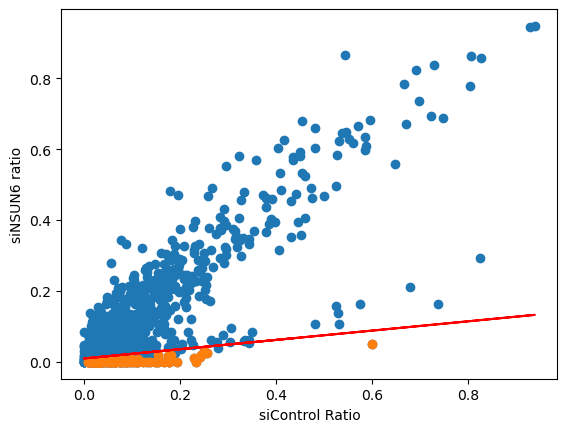

In [222]:
plt.scatter(ubsseq_data_significant['ratio_siControl'], ubsseq_data_significant['ratio_siNSUN6'], label='Data Points')
plt.xlabel('siControl Ratio')
plt.ylabel('siNSUN6 ratio')

a, b = np.polyfit(ubsseq_data_significant['ratio_siControl'], ubsseq_data_significant['ratio_siNSUN6'], 1)

# Not sure how to adjust, come back to this later
a = a - NSUN6_NSUN2_cutoff_factor

plt.plot(ubsseq_data_significant['ratio_siControl'], a * np.array(ubsseq_data_significant['ratio_siControl']) + b, color='red', label='Line of Best Fit')

# Joel's Test for Understanding
#gene_search = ubsseq_data_significant[ubsseq_data_significant['gene_name'] == "ENSG00000083444(PLOD1)"]
gene_search = ubsseq_data_significant[ubsseq_data_significant['delta_ratio'] > (1-a)]
plt.scatter(gene_search['ratio_siControl'], gene_search['ratio_siNSUN6'], label='Gene Search')

plt.show()

delta ratio will be (control - NSUN6) / control

!!! Need to adjust threshold to ensure more accurate reading of CTCCA motif comes through, otherwise NSUN2 modification is too present

In [223]:
print(f"Best fit gradient is {a:.2f} and y-intercept is {b:.2f}")
ideal_delta_threshold = 1 - a + b
print(f"Ideal data threshold should be above delta ratio {(ideal_delta_threshold) * 100:.2f}%")
ubsseq_data_NSUN6 = ubsseq_data_significant[ubsseq_data_significant['delta_ratio'] >= ideal_delta_threshold]
ubsseq_data_NSUN6_shape = ubsseq_data_NSUN6.shape
print(f"This threshold includes {ubsseq_data_NSUN6_shape[0]} samples out of the {ubsseq_data_significant_shape[0]} valid samples, a {ubsseq_data_NSUN6_shape[0]/ubsseq_data_significant_shape[0]*100:.2f}% retention")

#We might want to also explore data we assume not be modified by NSUN6, likely NSUN2
ubsseq_data_NSUN2 = ubsseq_data_significant[ubsseq_data_significant['delta_ratio'] < ideal_delta_threshold]

### Data clean
ubsseq_data_NSUN6=ubsseq_data_NSUN6.drop([
    'gene_type','gene_pos','unconverted','converted','ratio_siControl','ratio_siNSUN6','delta_ratio'
    ], axis=1)
ubsseq_data_NSUN2=ubsseq_data_NSUN2.drop([
    'gene_type','gene_pos','unconverted','converted','ratio_siControl','ratio_siNSUN6','delta_ratio'
    ], axis=1)

Best fit gradient is 0.13 and y-intercept is 0.01
Ideal data threshold should be above delta ratio 87.86%
This threshold includes 106 samples out of the 1594 valid samples, a 6.65% retention


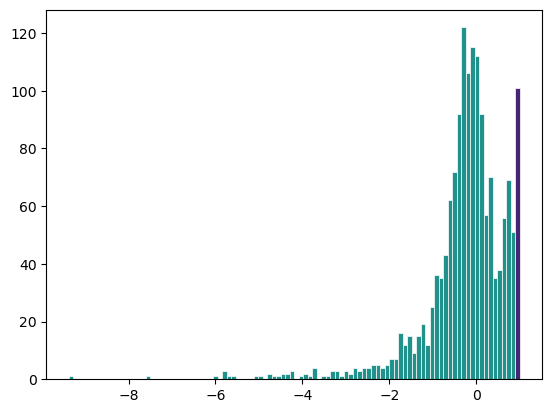

In [224]:
### distribution of data by delta ratio
distribution_data = ubsseq_data_significant['delta_ratio']

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = plt.hist(distribution_data.to_list(), bins=100, linewidth=0.5, edgecolor="white")

# Now, we'll loop through our objects and set the color of each accordingly
for thisbin, thispatch in zip(bins, patches):
    if(thisbin > ideal_delta_threshold):
        color = plt.cm.viridis(0.1)
    else:
        color = plt.cm.viridis(0.5)
    thispatch.set_facecolor(color)

plt.show()


## Sequence Extraction


Extend by 50:50, 30:70, 70:30 for each sequence - always length of 101

In [225]:
## Use the samples in df 'ubsseq_data_likely_NSUN6_modified'

ubsseq_data_NSUN6['chrom'] = ubsseq_data_NSUN6['chrom'].replace(
    [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 'X'], 
    ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX'])

#likely_NSUN6_modified_seq_extracted = ubsseq_data_likely_NSUN6_modified;
seq_extract = [[],[],[]];

for ind in ubsseq_data_NSUN6.index:
    gene = ubsseq_data_NSUN6['gene_name'][ind]
    chrome = ubsseq_data_NSUN6['chrom'][ind]
    strand = ubsseq_data_NSUN6['strand'][ind]
    pos = ubsseq_data_NSUN6['pos'][ind]
    seq_extract[0].append(extract_seq_genome("hg38", chrome, pos-1-50, pos+50, strand)) #50:50
    seq_extract[1].append(extract_seq_genome("hg38", chrome, pos-1-30, pos+70, strand)) #30:70
    seq_extract[2].append(extract_seq_genome("hg38", chrome, pos-1-70, pos+30, strand)) #70:30

ubsseq_NSUN6_extracted = ubsseq_data_NSUN6.assign(
    seq5050=seq_extract[0], seq3070=seq_extract[1], seq7030=seq_extract[2])

The same can be done for the samples likely not modified by NSUN6

In [226]:
ubsseq_data_NSUN2['chrom'] = ubsseq_data_NSUN2['chrom'].replace(
    [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 'X'], 
    ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX'])

#likely_NSUN6_modified_seq_extracted = ubsseq_data_likely_NSUN6_modified;
seq_extract = [[],[],[]];

for ind in ubsseq_data_NSUN2.index:
    gene = ubsseq_data_NSUN2['gene_name'][ind]
    chrome = ubsseq_data_NSUN2['chrom'][ind]
    strand = ubsseq_data_NSUN2['strand'][ind]
    pos = ubsseq_data_NSUN2['pos'][ind]
    seq_extract[0].append(extract_seq_genome("hg38", chrome, pos-1-50, pos+50, strand)) #50:50
    seq_extract[1].append(extract_seq_genome("hg38", chrome, pos-1-30, pos+70, strand)) #30:70
    seq_extract[2].append(extract_seq_genome("hg38", chrome, pos-1-70, pos+30, strand)) #70:30

ubsseq_NSUN2_extracted = ubsseq_data_NSUN2.assign(
    seq5050=seq_extract[0], seq3070=seq_extract[1], seq7030=seq_extract[2])


## Motif Sequence Logo


Generate a sequence logo. To do so we focus on the nucleotides immediately adjacent to the methylated 'C' theoretically in index 50. This value should be in the centre of each extended sequence so we will just take the values from 45 to 56. 

Text(0, 0.5, 'Information (bits)')

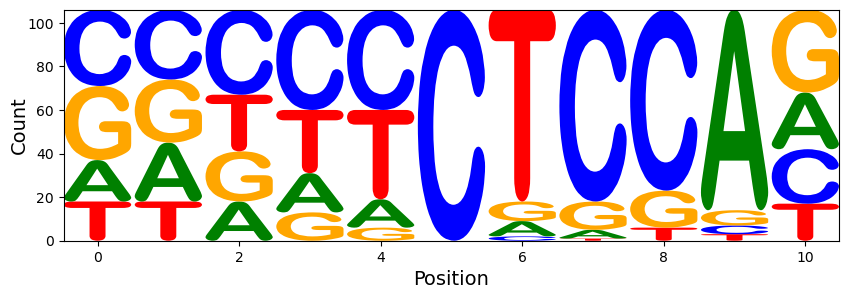

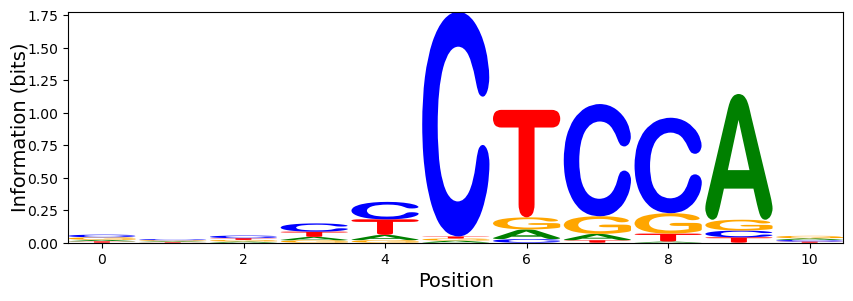

In [227]:
ubsseq_NSUN6_extracted_5050 = ubsseq_NSUN6_extracted['seq5050'].to_list()
for i in range (0, len(ubsseq_NSUN6_extracted_5050)):
    ubsseq_NSUN6_extracted_5050[i] = ubsseq_NSUN6_extracted_5050[i][45:56]
counts_mat = lm.alignment_to_matrix(ubsseq_NSUN6_extracted_5050)

# Counts matrix -> Information matrix
info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')

logo_count = lm.Logo(df=counts_mat,
               font_name='Arial Rounded MT Bold',
               figsize=(10,3)) # Can change to plot entropy or percentage instead of count
logo_count.ax.set_xlabel('Position',fontsize=14)
logo_count.ax.set_ylabel('Count', labelpad=-1,fontsize=14)

logo_info = lm.Logo(df=info_mat,
               font_name='Arial Rounded MT Bold',
               figsize=(10,3)) # Can change to plot entropy or percentage instead of count
logo_info.ax.set_xlabel('Position',fontsize=14)
logo_info.ax.set_ylabel('Information (bits)', labelpad=-1,fontsize=14)

The above sequence logo shows that all of the data is correctly centred around the sampled cytosine and also shows the known NSUN6 motif 'CTCCA' (or 'CUCCA' but T<->U).

Now we can explore the data that was cut off in a second sequence logo

Text(0, 0.5, 'Information (bits)')

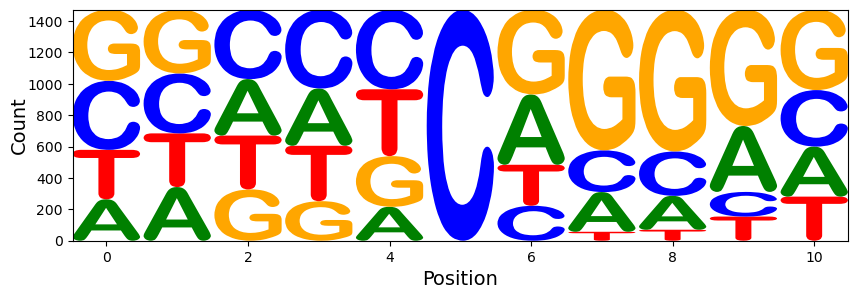

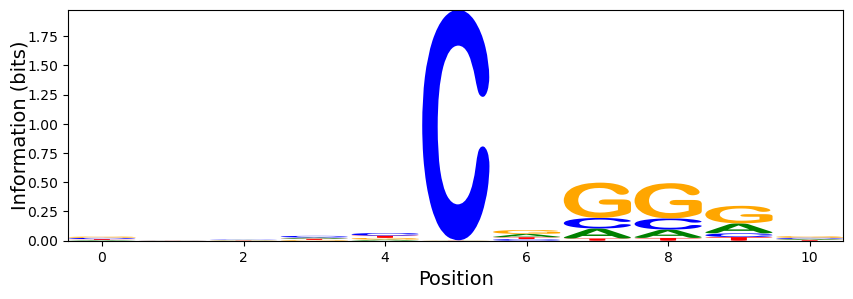

In [228]:
ubsseq_NSUN2_extracted_5050 = ubsseq_NSUN2_extracted['seq5050'].to_list()
for i in range (0, len(ubsseq_NSUN2_extracted_5050)):
    ubsseq_NSUN2_extracted_5050[i] = ubsseq_NSUN2_extracted_5050[i][45:56]
counts_mat = lm.alignment_to_matrix(ubsseq_NSUN2_extracted_5050)

# Counts matrix -> Information matrix
info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')

logo_count = lm.Logo(df=counts_mat,
               font_name='Arial Rounded MT Bold',
               figsize=(10,3)) # Can change to plot entropy or percentage instead of count
logo_count.ax.set_xlabel('Position',fontsize=14)
logo_count.ax.set_ylabel('Count', labelpad=-1,fontsize=14)

logo_info = lm.Logo(df=info_mat,
               font_name='Arial Rounded MT Bold',
               figsize=(10,3)) # Can change to plot entropy or percentage instead of count
logo_info.ax.set_xlabel('Position',fontsize=14)
logo_info.ax.set_ylabel('Information (bits)', labelpad=-1,fontsize=14)


## Saving Back To Fasta


Add them to a fasta file. Label fasta entries as...
- posx-50-50
- posx-30-70
- posx-70-30

In [229]:

NSUN6_5050_fasta = []
NSUN6_3070_fasta = []
NSUN6_7030_fasta = []
for ind in ubsseq_NSUN6_extracted.index:
    gene_name = ubsseq_NSUN6_extracted['gene_name'][ind]
    NSUN6_5050_fasta.append('>%s\n%s' % (gene_name, ubsseq_NSUN6_extracted['seq5050'][ind]))
    NSUN6_3070_fasta.append('>%s\n%s' % (gene_name, ubsseq_NSUN6_extracted['seq3070'][ind]))
    NSUN6_7030_fasta.append('>%s\n%s' % (gene_name, ubsseq_NSUN6_extracted['seq7030'][ind]))

with open('out/demo_NSUN6_extended_5050.fasta', 'w') as file:
     file.write('\n'.join(NSUN6_5050_fasta))

with open('out/demo_NSUN6_extended_3070.fasta', 'w') as file:
     file.write('\n'.join(NSUN6_3070_fasta))

with open('out/demo_NSUN6_extended_7030.fasta', 'w') as file:
     file.write('\n'.join(NSUN6_7030_fasta))